In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.patches as mpatches
from matplotlib import rc
from matplotlib import animation
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
import seaborn.apionly as sns

import re
import os
import glob
import datetime
%matplotlib inline

In [2]:
rc('font', size=8)
rc('font', family='Arial')
rc('axes', linewidth=1)
rc('xtick.major', width=0.5, size=1.5)
rc('ytick.major', width=0.5, size=1.5)
rc('mathtext', default='regular')

In [3]:
colors = ['#F9ED69', '#F08A5D', '#B83B5E', '#6A2C70']
colors.reverse()

# Figure 7

In [4]:
def load_outputs(exp_names):
    
    output_df = pd.DataFrame()
    output_df = pd.DataFrame(columns=['RT','XS','T','NA','MA','BA','TA'])
    
    for exp_name in exp_names:
        path = os.path.join('../optimisations/', exp_name, 'reactor_output', exp_name.replace('_', '')+'.outputs.*.txt')
        files = sorted(glob.glob(path))
        
        for file in files:
            output = np.loadtxt(file)
                    
            try:
                df = pd.DataFrame(output, columns=['RT','XS','T','NA','MA','BA','TA'])
            except:
                df = pd.DataFrame(data=[output],
                                  columns=['RT','XS','T','NA','MA','BA','TA'])

            df['exp_name'] = exp_name
            output_df = output_df.append(df,ignore_index=True)
    
    return output_df

In [5]:
def load_summaries(exp_names):
    path = os.path.join('../optimisations/', exp_name, exp_name.replace('_', '')+'.summary.csv')
    summary_df = pd.DataFrame()
    for exp_name in exp_names:
        
        df = pd.read_csv(path)
        summary_df = summary_df.append(df, ignore_index=True)
        
    return summary_df

In [6]:
def load_results(exp_names):
    
    results_df = pd.DataFrame()
    for exp_name in exp_names:
        path = os.path.join('../optimisations/', exp_name, exp_name.replace('_', '')+'.results.csv')
        df = pd.read_csv(path)
        df['exp_name'] = exp_name
        results_df = results_df.append(df, ignore_index=True)
        
    return results_df

In [7]:
def make_frames(exp_names):
    
    outputs = load_outputs(exp_names)
    results = load_results(exp_names)
    
    return outputs, results

In [8]:
exp_names = ['run_I','run_II','run_III','run_IV', 'run_V', 'run_VI']
outputs, results = make_frames(exp_names)
summaries = pd.read_csv('../optimisations/optimisations.summary.csv', index_col=0)

In [9]:
summaries

,method,function,soft_function1,soft_function2,xy_max,xy_min,max_ratio,min_ratio,z_max,z_min,F1_1,F1_2,F2_1,F2_2,sigma1,sigma2,f0,Delta
exp_name,,,,,,,,,,,,,,,,,,
runI,normal,[X3],NaN,NaN,310,30,2,0.5,150,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
runII,soft,[X3],1 - [X1] - [X2],NaN,310,30,2,0.5,150,100,0.0,NaN,0.1,NaN,0.3,0.3,0.0128,0.0434
runIII,soft,[X3],1 - [X1] - [X2],[X1] / [X2],310,30,2,0.5,150,100,0.0,4.0,0.1,inf,0.3,0.3,0.0104,0.0254
runIV,soft,[X3],1 - [X1] - [X2],[X1] / [X2],310,30,2,0.5,150,100,0.0,0.0,0.1,0.500000,0.3,0.3,0.8546,0.6753
runV,soft,[X3],1 - [X1] - [X2],[X1] / [X2],310,30,2,0.5,150,100,0.0,0.0,0.1,1.500000,0.3,0.3,0.0849,0.3005
runVI,soft,[X1] / [X2],1 - [X1] - [X2],NaN,310,30,2,0.5,150,100,0.0,NaN,0.1,NaN,0.3,0.3,1.3931,1.1685


In [10]:
# make a df of best points
df_best = results[results.f == results.f[results.exp_name == 'run_I'].min()]
df_best = df_best.append(results[results.f == results.f[(results.exp_name =='run_II') & 
                                                        (results.fcon1 <= summaries.F2_1.loc['runII'])
                                                       ].min()])
df_best = df_best.append(results[results.f == results.f[(results.exp_name == 'run_III') & 
                                                        (results.fcon1 <= summaries.ix['runIII', 'F2_1']) &
                                                        (results.fcon2 >= summaries.ix['runIII', 'F1_2'])
                                                       ].min()])
df_best = df_best.append(results[results.f == results.f[(results.exp_name == 'run_IV')].min()])

df_best = df_best.append(results.iloc[results.f[(results.exp_name == 'run_V') &
                                                (results.fcon1 <= summaries.ix['runV', 'F2_1']) &
                                                (results.fcon2 <= summaries.ix['runV', 'F2_2'])
                                               ].argmin()])

df_best = df_best.append(results.iloc[results.f[(results.exp_name == 'run_VI') &
                                                (results.fcon1 <= summaries.ix['runVI', 'F2_1'])
                                               ].argmin()])
df_best

,exp_name,f,fcon1,fcon2,fobj,v1,v2,v3,x1,x2,x3
52,run_I,0.000865,NaN,NaN,NaN,0.133935,0.999871,105.40,190.728720,119.231280,105.40
191,run_II,-0.122777,0.095441,NaN,0.006747,0.156387,0.134581,102.85,26.478293,15.241707,102.85
298,run_III,-0.039443,0.094018,6.065021,0.009357,0.161806,0.476903,118.70,94.519040,53.320960,118.70
315,run_IV,-0.212171,0.202314,0.564470,0.201350,-0.193548,0.509419,125.35,52.640000,105.280000,125.35
420,run_V,0.000000,0.091407,1.432681,0.084880,-0.080129,0.249290,106.80,33.307680,43.972320,106.80
504,run_VI,0.000000,0.094376,NaN,1.393142,-0.179613,0.450710,102.30,48.249973,91.470027,102.30


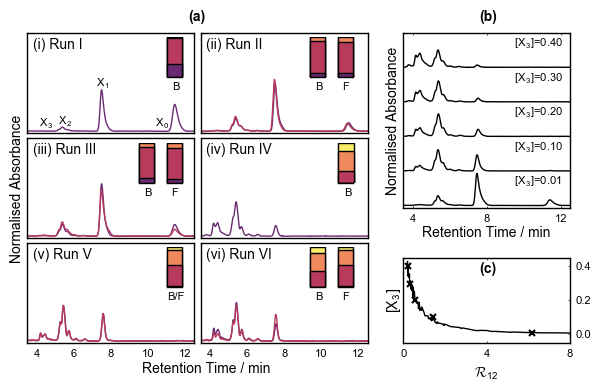

In [11]:
fig = plt.figure(figsize=(7,4))

grid = GridSpec(21, 19)

ax1 = plt.subplot(grid[:7,:6])
ax2 = plt.subplot(grid[:7,6:12])
ax3 = plt.subplot(grid[7:14,:6])
ax4 = plt.subplot(grid[7:14,6:12])
ax5 = plt.subplot(grid[14:,:6])
ax6 = plt.subplot(grid[14:,6:12])
ax7 = plt.subplot(grid[:12, 13:])
ax8 = plt.subplot(grid[15:, 13:])

colors = colors
text_grey = (121/255, 121/255, 121/255)

alpha = 1

lefts = [0.32, 0.524, 0.28, 0.565, 0.32, 0.524]
bottoms = [0.79, 0.79, 0.525, 0.525, 0.265, 0.265]
width = 0.09 * 2/6

axes = (ax1, ax2, ax3, ax4, ax5, ax6)
colors2 = colors
titles = ['i', 'ii', 'iii', 'iv', 'v', 'vi']

outputs['stack_MA'] = outputs.NA + outputs.MA
outputs['stack_BA'] = outputs.stack_MA + outputs.BA
outputs['stack_TA'] = outputs.stack_BA + outputs.TA

for i, ax in enumerate(axes):
    name = exp_names[i]
    short_name = name.replace('_', '')
    chromatogram_path = os.path.join('../optimisations/', name, name.replace('_', '')+'.chromatograms.csv')
    
    left = lefts[i]
    bottom = bottoms[i]

    result = results.loc[results.exp_name == name]
    output = outputs.loc[outputs.exp_name == name]
                                     
    start_ind = result.index.values[0]
                                     
    chromatograms = pd.read_csv(chromatogram_path)
    time = chromatograms.time / 60
    
    jbest = result[result.f == result.f.min()].index.values[0] - start_ind

    if not all(result.fcon1.isnull()):
        if not all(result.fcon2.isnull()):
            soft_value = result.f[(result.fcon1 >= summaries.ix[short_name, 'F1_1']) & \
                                  (result.fcon1 <= summaries.ix[short_name, 'F2_1']) & \
                                  (result.fcon2 >= summaries.ix[short_name, 'F1_2']) & \
                                  (result.fcon2 <= summaries.ix[short_name, 'F2_2'])].min()
                                     
            soft_value = soft_value
            if np.isnan(soft_value):
                jsoft = None
            else:
                jsoft = result[result.f == soft_value].index.values[0] - start_ind
        else:
            soft_value = result.f[(result.fcon1 >= summaries.ix[short_name, 'F1_1']) & \
                                  (result.fcon1 <= summaries.ix[short_name, 'F2_1'])].min()
            jsoft = result[result.f == soft_value].index.values[0] - start_ind
    else:
        jsoft = None
    
    area = np.trapz(chromatograms.ix[chromatograms.ix[:,jbest+1].notnull(), jbest+1])
    ax.plot(time, chromatograms.ix[:,jbest+1] / area, color=colors2[0], 
            lw=1, alpha=alpha, label='$f_\mathrm{best}$')
                                     
    if jsoft:
        area = np.trapz(chromatograms.ix[chromatograms.ix[:,jsoft+1].notnull(), jsoft+1])
        ax.plot(time, chromatograms.ix[:, jsoft+1] / area, color=colors2[1], 
                lw=1, label='$f_\mathrm{soft}$')
    
    ax.get_yaxis().set_ticks([])
    ax.tick_params(axis=u'both', which=u'both',length=0)
    
    inset = plt.axes([left, bottom, width, 0.1])
    inset.set_xticks([])
    
    if i == 4:
        inset.text(0.8, -0.25, 'B/F', va='center', ha='center', fontsize=8)
    else:
        inset.text(0.8, -0.25, 'B', va='center', ha='center', fontsize=8)
    
    keys = ['stack_TA','stack_BA','stack_MA','NA']

    for j in range(4):
        inset.bar(0.5, output[keys[j]].iloc[jbest], 0.5, color=colors[3 - j])
        
    inset.set_ylim(0, 1)
    inset.set_yticks([])
    inset.set_xlim(0.4, 1.1)
    inset.spines['top'].set_visible(False)
    inset.spines['right'].set_visible(False)
    inset.spines['left'].set_visible(False)
    inset.spines['bottom'].set_linewidth(1)
    inset.spines['bottom'].set_smart_bounds(True)
    inset.xaxis.set_ticks_position('bottom')
    
    if i in [1, 2, 5]:
        inset2 = plt.axes([left + width + 0.01, bottom, width, 0.1])
        inset2.set_xticks([])
        inset2.text(0.75, -0.25, 'F', va='center', ha='center', fontsize=8)
        for j in range(4):
            inset2.bar(0.5, output[keys[j]].iloc[jsoft], 0.5, color=colors[3 - j])
            
        inset2.set_ylim(0, 1)
        inset2.set_yticks([])
        inset2.set_xlim(0.4, 1.1)
        inset2.spines['top'].set_visible(False)
        inset2.spines['right'].set_visible(False)
        inset2.spines['left'].set_visible(False)
        inset2.spines['bottom'].set_linewidth(1)
        inset2.spines['bottom'].set_smart_bounds(True)
        inset2.xaxis.set_ticks_position('bottom')
    
    ax.set_xlim((3.5, 12.5))
    ax.set_ylim((-0.001, 0.06))
    
    title = '({}) Run {}'.format(titles[i], titles[i].upper())
    ax.annotate(title, xy=(0.03, 0.95), xycoords='axes fraction', fontsize=10, va='top')

ax1.text(4.1, 0.003, 'X$_3$', fontsize=8)
ax1.text(5.14, 0.004, 'X$_2$', fontsize=8)
ax1.text(7.22, 0.027, 'X$_1$', fontsize=8)
ax1.text(10.4, 0.003, 'X$_0$', fontsize=8)

fig.text(0.38, 0.06, 'Retention Time / min', fontsize=10, va='center', ha='center')
fig.text(0.11, 0.51, 'Normalised Absorbance', rotation=90, fontsize=10, va='center', ha='center')

results1 = pd.read_csv('../optimisations/run_IV/runIV.results.csv')
outputs1 = load_outputs(['run_IV'])
df1 = results1.join(outputs1)
df1['MA_over_BA'] = df1.MA / df1.BA
df1 = df1.sort_values(by='MA_over_BA')
chromatograms1 = pd.read_csv('../optimisations/run_IV/runIV.chromatograms.csv')

ax8.plot(df1.MA_over_BA, df1.TA, lw=1, color='k')


for i, value in enumerate([0.01, 0.1, 0.2, 0.3, 0.4]):
    idx = df1[abs(df1.TA - value) == abs(df1.TA - value).min()].index.values[0]
    amount = df1.TA.loc[idx]
    ax8.plot(df1.MA_over_BA.loc[idx], amount, 'x', color='none', mew=1.5, mec='k', markersize=5)
    area = np.trapz(chromatograms1.ix[chromatograms1.ix[:, idx+1].notnull(), idx+1])
    ax7.plot(time, chromatograms1.ix[:, idx+1] / area + i*0.03, lw=1, 
                   color='k', label='{:.1f}'.format(value))
    
    ax7.text(9.5,0.018 + i*0.03,'[X$_3$]'+'={:.2f}'.format(amount), color='k', fontsize=8)

ax7.set_ylim(-0.002, 0.15)
ax7.set_xlim(3.5, 12.5)
ax7.set_xticks([4, 8, 12])
ax7.set_xlabel('Retention Time / min', fontsize=10, labelpad=2)
ax7.set_ylabel('Normalised Absorbance', fontsize=10, labelpad=2)
ax7.set_yticks([])

ax8.set_ylim(-0.05, 0.45)
ax8.set_xlim(0, 8)
ax8.set_yticks([0, 0.2, 0.4])
ax8.set_xticks([0, 4, 8])
ax8.yaxis.tick_right()
ax8.set_xlabel('$\mathcal{R}_{12}$', fontsize=10)
ax8.set_ylabel('[X$_3$]', fontsize=10, labelpad=0)

fig.text(0.355, 0.93, '(a)', fontsize=10, fontweight='bold')
fig.text(0.77, 0.93, '(b)', fontsize=10, fontweight='bold')
fig.text(0.77, 0.3, '(c)', fontsize=10, fontweight='bold')

fig.subplots_adjust(hspace=0.5, wspace=0.3)

In [12]:
results.ix[(results.exp_name == 'run_IV'), ['RT', 'XS','T','NA','MA','BA','TA']].iloc[17]

RT   NaN
XS   NaN
T    NaN
NA   NaN
MA   NaN
BA   NaN
TA   NaN
Name: 317, dtype: float64